<a href="https://colab.research.google.com/github/voroninvisuals/google-colab-notebooks/blob/main/Depth_Estimation_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3d Visualization of Depth Maps Generated using MiDaS

*Author: John Robinson*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


## Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) is a machine learning model that outputs per pixel depth estimates given a single image (ie monocular depth estimation). There are a number of different models provided in the associated github repository.  This notebook will use the largest (highest quality) model for demonstration purposes.

The focus of this notebook is to demonstrate a 3d visualization of depth maps generated using MiDas. The 3d visualization leverages a simple 3d point cloud viewer that runs in the notebook itself.  This viewer was created using three.js.  More about depth estimation can be found in this [associated blog article](https://www.storminthecastle.com/posts/ufos_and_depth/).

----------------------------------------------------------------------
## This notebook should be used with GPU acceleration please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"
----------------------------------------------------------------------


## Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 27.4 MB/s 
     |████████████████████████████████| 163 kB 60.7 MB/s 


In [ ]:
# Load and setup the MiDAS model
import cv2
import numpy as np
import urllib
import torch
import urllib.request
import matplotlib.pyplot as plt
import tempfile
import warnings
warnings.filterwarnings('ignore') #squelch warnings

model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## A function that will use the MiDaS model to generate a depth map from and image

In [ ]:
# Given a numpy array representing an input image use the MiDAS model to generate a depth map
# assumes rgb color space
def process_image(input):
  input_batch = transform(input).to(device)
  with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=input.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
  output = prediction.cpu().numpy()
  output = ((output-np.min(output))/np.max(output))*255 # normalize 
  return output

In [ ]:
#@title
# Given a url to an image; display the image and its MiDAS calculated depth map
def show_image_with_depth(url):
  filename = tempfile.mktemp()
  urllib.request.urlretrieve(url, filename)
  input_image = cv2.imread(filename)  # load the image data into a numpy array
  input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB) # convert the image array into the expected RGB colorspace
  depth_map = process_image(input_image) # generate the depth map using the MiDAS model
  
  plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  plt.imshow(input_image)
  plt.subplot(1,2,2)
  plt.imshow(depth_map,cmap='gray')

##Show a few examples of MiDas generated depth maps.

Darker pixels are further away and lighter pixels are closer.

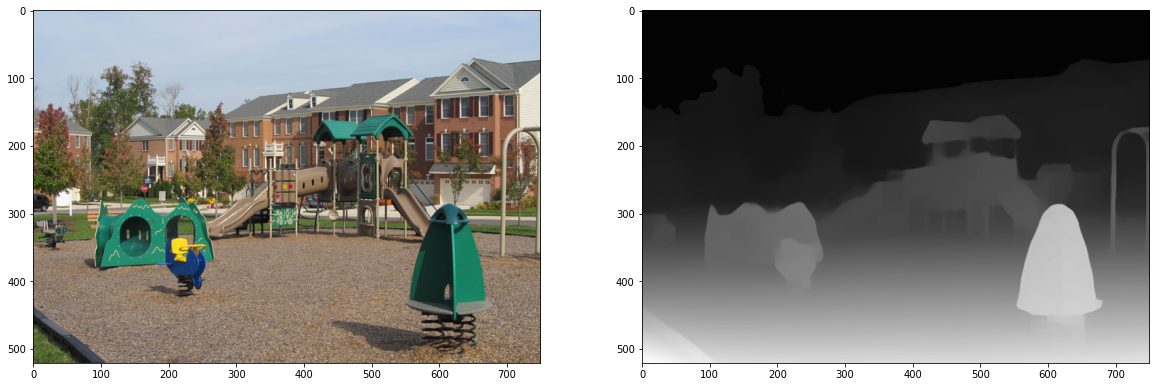

In [ ]:
show_image_with_depth('https://tujot.com/thr/park.jpg')

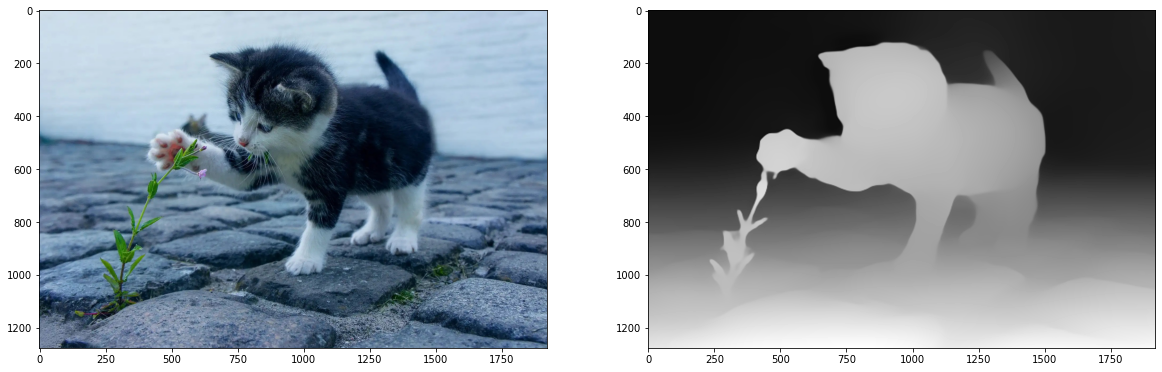

In [ ]:
show_image_with_depth('https://tujot.com/thr/kitten.jpg')

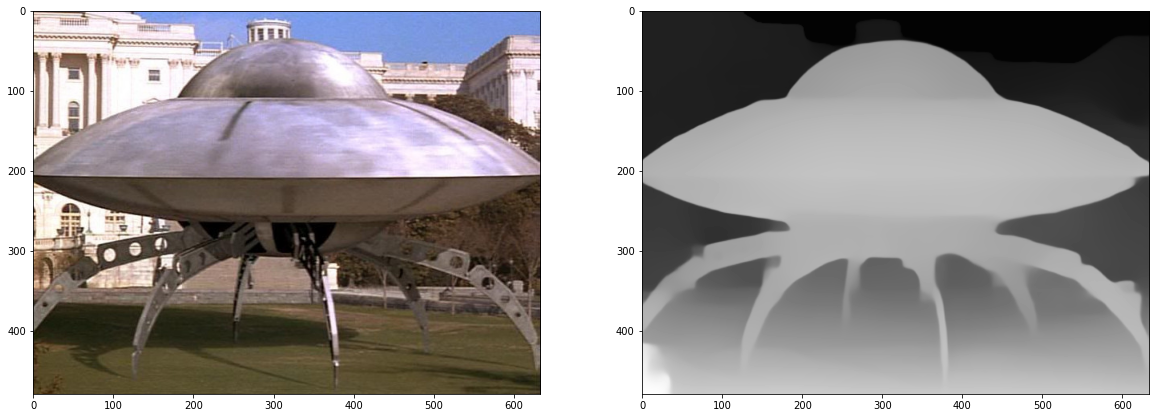

In [ ]:
show_image_with_depth('https://tujot.com/thr/marsattacks.jpg')

## HTML code for the 3d visualizer that will be loaded into an iframe later in this notebook

In [ ]:
depthviewer = '''
<html>

<head>
    <style>
        body {
            overflow: hidden;
            margin: 0;
        }
    </style>
    <script>
        var blah;

        function getImageData( image ) {
            var canvas = document.createElement( 'canvas' );
            canvas.width = image.width;
            canvas.height = image.height;

            var context = canvas.getContext( '2d' );
            context.drawImage( image, 0, 0 );

            return context.getImageData( 0, 0, image.width, image.height );
        }

        window.onload = (e) => {
            var scene = new THREE.Scene();
            scene.background = new THREE.Color( 0xffffff );
            var camera = new THREE.PerspectiveCamera(60, window.innerWidth / window.innerHeight, 0.1, 1000);
            camera.position.set(0, 0, 2);
            var renderer = new THREE.WebGLRenderer({
                antialias: true
            });
            renderer.setSize(window.innerWidth, window.innerHeight);
            document.body.appendChild(renderer.domElement);

            var controls = new THREE.OrbitControls(camera, renderer.domElement);

            var reset = document.getElementById('reset')
            reset.addEventListener('click', e => controls.reset())

            function vertexShader() {
                return document.getElementById("vshader").text
            }

            function fragmentShader() {
                return document.getElementById("fshader").text
            }

            // The url for the image is passed in to the web application
            var p = new URLSearchParams(window.location.search);
            var image_url = p.get("image");
            var depth_url = '/depth?image='+image_url;


            var texture = new THREE.TextureLoader().load(image_url, t => {
                var w = t.image.width;
                var h = t.image.height;
                var max = Math.max(w, h);
                var ar = w / h;

                blah = getImageData(t.image);

                console.log('texture:', getImageData(t.image).data)
                
                var planeGeometry = new THREE.PlaneGeometry(w / max, h / max, w, h);
                var depth = new THREE.TextureLoader().load(depth_url);

                uniforms = {
                    image: { type: "t", value: texture },
                    depth: { type: "t", value: depth },
                    ar: { type: 'f', value: ar }
                }

                let planeMaterial = new THREE.ShaderMaterial({
                    uniforms: uniforms,
                    fragmentShader: fragmentShader(),
                    vertexShader: vertexShader(),
                    side: THREE.DoubleSide
                });

                var points = new THREE.Points(planeGeometry, planeMaterial)

                points.position.set(0, 0, 0)

                scene.add(points)

                render();
            });

            function render() {
                requestAnimationFrame(render);
                renderer.render(scene, camera);
            }
        }
    </script>
</head>

<body>
    <script src="https://threejs.org/build/three.min.js"></script>
    <script src="https://threejs.org/examples/js/controls/OrbitControls.js"></script>

    <script id="vshader" type="x-shader/x-vertex">
        uniform sampler2D depth;
        uniform float ar;
        varying vec3 vUv; 
        vec3 pos;
    
        void main() {
          vUv = position; 
          pos = position;
          pos.z = texture2D(depth,(vec2(vUv.x,vUv.y*ar)+0.5)).r;
    
          float s = 2.0 - pos.z;
          pos.x = pos.x * s;
          pos.y = pos.y * s;
    
          vec4 modelViewPosition = modelViewMatrix * vec4(pos, 1.0);
          gl_Position = projectionMatrix * modelViewPosition; 
          gl_PointSize = 2.0;
        }
    </script>
    <script id="fshader" type="x-shader/x-fragment">
        uniform sampler2D image;
        uniform float ar;
        varying vec3 vUv;
  
        void main() {
          gl_FragColor = texture2D(image,(vec2(vUv.x,vUv.y*ar)+0.5));
        }
    </script>

    <div style="position:absolute">
        <button id="reset">Reset</button>
    </div>
</body>

</html>

'''

## Run a simple flask application server within this notebook
This application server will allow us to run a full web app nested within this notebook.  This web app will be able to access the resources of the colab notebook including the GPU associated with the colab notebook.

In [ ]:
from flask.helpers import make_response
# Run a python(flask)-based web service in your note book
# You can reload this cell to restart the server if you make changes

default_port = 6060

from werkzeug.serving import make_server
from flask import Flask, request
import threading

class ServerThread(threading.Thread):

    def __init__(self, app, port):
        threading.Thread.__init__(self)
        self.port = port
        self.srv = make_server('127.0.0.1', port, app)
        self.ctx = app.app_context()
        self.ctx.push()

    def run(self):
        print('starting server on port:',self.port)
        self.srv.serve_forever()

    def shutdown(self):
        self.srv.shutdown()

def start_server(port=default_port):
    global server
    if 'server' in globals() and server:
      print('stopping server')
      stop_server()

    app = Flask('myapp')

    # you can add your own routes here as needed
    @app.route("/")
    def Hello():
      response = make_response(depthviewer)
      response.headers["Access-Control-Allow-Origin"] = '*'
      return response

    @app.route("/depth")
    def depth():
      url = request.args.get('image')
      resp = urllib.request.urlopen(url)
      input_image = np.asarray(bytearray(resp.read()), dtype="uint8")
      input_image = cv2.imdecode(input_image, cv2.IMREAD_COLOR)
      input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
      depth_map = process_image(input_image)
      retval, buffer = cv2.imencode('.png',depth_map)
      response = make_response(buffer.tobytes())
      response.headers['Content-Type'] = 'image/png'
      response.headers["Access-Control-Allow-Origin"] = '*'
      return response

    server = ServerThread(app,port)
    server.start()

def stop_server():
    global server
    if server:
      server.shutdown()
      server = None

# Start the server here
start_server()

starting server on port: 6060


## Utility function to dynamically create an iframe within this notebook

In [ ]:
# By executing this cell you will dynamically create an iframe within this cell of your notebook
# this iframe can load an arbitrary web application which can access the flask webservice that is running
# within this notebook.

import IPython.display

def display(port, height, image):
    image = urllib.parse.quote_plus(image)
    shell = """
        (async () => {
            const url = await google.colab.kernel.proxyPort(%PORT%, {"cache": true});
            const iframe = document.createElement('iframe');
            iframe.src = url+'?image=%IMAGE%';
            iframe.setAttribute('width', '100%');
            iframe.setAttribute('height', '%HEIGHT%');
            iframe.setAttribute('frameborder', 0);
            document.body.appendChild(iframe);
        })();
    """
    replacements = [
        ("%PORT%", "%d" % port),
        ("%HEIGHT%", "%d" % height),
        ("%IMAGE%", "%s" % image)
    ]
    for (k, v) in replacements:
        shell = shell.replace(k, v)

    script = IPython.display.Javascript(shell)
    IPython.display.display(script)

## 3D Visualization - Pulling it all together
Here we visualize an image in 3d leveraging the generated depth map.

**Use your mouse** to drag the image below to experience the 3d visualization.  You can also zoom in and zoom out using your mouse wheel.

**Click the Reset Button** to reset the camera.

A few sample image URLs have been provided below for reference.  But try out your own.

In [ ]:

display(default_port, 720, 'https://tujot.com/thr/marsattacks.jpg')
#display(default_port, 720, 'https://tujot.com/thr/kitten.jpg')
#display(default_port, 720, 'https://tujot.com/thr/park.jpg')
#display(default_port, 720, 'https://tujot.com/thr/dog.jpg')
#display(default_port, 720, 'https://images.immediate.co.uk/production/volatile/sites/4/2018/08/iStock_000053391012_Large-78706ea.jpg?webp=true&quality=90&resize=940%2C399')
#display(default_port, 720, 'https://tujot.com/thr/lion.jpg')
#display(default_port,720, 'https://tujot.com/thr/whitewhale.jpg')


<IPython.core.display.Javascript object>

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)
